#Detección de máscaras faciales mediante red neuronal convolucional profunda

## 1 Tratamiento de datos

### 1.1 Data de entrenamiento

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
!gdown https://drive.google.com/uc?id=1ftDIJ-8Djf1-W5aZ2ulR1G8eJ4OA2_22
!unzip archive.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/Wi

In [3]:
train_data = image_dataset_from_directory('Face Mask Dataset/Train/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
test_data = image_dataset_from_directory('Face Mask Dataset/Test/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
valid_data = image_dataset_from_directory('Face Mask Dataset/Validation/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)

Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


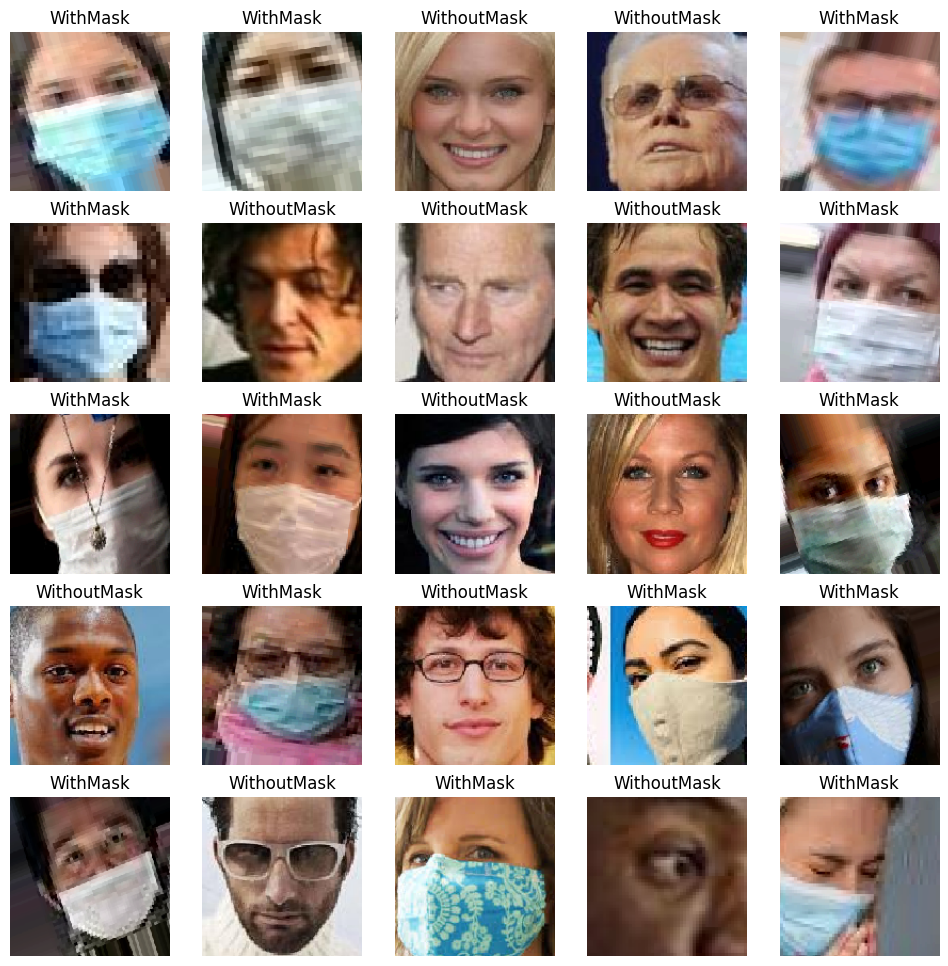

In [4]:
#Ver imágenes aleatorias
classes_train = train_data.class_names
plt.figure(figsize=(12,12))
for img, label in train_data.take(1):
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')

In [5]:
#Cargar la data de entrenamiento
image_path = 'Face Mask Dataset/Train'
classes = os.listdir('Face Mask Dataset/Train')

In [6]:
#dimensión de una imágen
img_train_1 = cv2.imread('Face Mask Dataset/Train/WithMask/10.png')
print(img_train_1.shape)

img_train_2 = cv2.imread('Face Mask Dataset/Train/WithMask/100.png')
print(img_train_2.shape)

(82, 82, 3)
(25, 25, 3)


In [7]:
# Clases disponibles
image_list_ = os.listdir(image_path)
print ("Clases: ",len(image_list_),",", image_list_)

Clases:  2 , ['WithoutMask', 'WithMask']


In [8]:
images = []
outputs = []

for i in classes:
    imageList = os.listdir(image_path + "/" + i)
    for j in imageList:
        img = cv2.imread(image_path + "/" + i + "/" + j)
        img = cv2.resize(img, (32,32))
        images.append(img)
        outputs.append(i)

In [9]:
x_train = np.array(images)
y_train = np.array(outputs)
print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)

x_train shape :  (10000, 32, 32, 3)
y_train shape :  (10000,)


### 1.2 Data de validación

In [10]:
#Cargando la data de validación
image_path_2 = 'Face Mask Dataset/Validation'
classes = os.listdir('Face Mask Dataset/Validation')

In [11]:
image_list_2 = os.listdir(image_path_2)
print ("Clases: ",len(image_list_2),",", image_list_2)

Clases:  2 , ['WithoutMask', 'WithMask']


In [12]:
images = []
outputs = []

for i in classes:
    imageList = os.listdir(image_path_2 + "/" + i)
    for j in imageList:
        img = cv2.imread(image_path_2 + "/" + i + "/" + j)
        img = cv2.resize(img, (32,32))
        images.append(img)
        outputs.append(i)

In [13]:
x_validation = np.array(images)
y_validation = np.array(outputs)
print("x_validation shape : ", x_validation.shape)
print("y_validation shape : ", y_validation.shape)

x_validation shape :  (800, 32, 32, 3)
y_validation shape :  (800,)


### 1.3 Data de prueba

In [14]:
#Cargando la data de prueba
image_path_3 = 'Face Mask Dataset/Test'
classes = os.listdir('Face Mask Dataset/Test')

In [15]:
image_list_3 = os.listdir(image_path_3)
print ("Clases: ",len(image_list_3),",", image_list_3)

Clases:  2 , ['WithoutMask', 'WithMask']


In [16]:
images = []
outputs = []

for i in classes:
    imageList = os.listdir(image_path_3 + "/" + i)
    for j in imageList:
        img = cv2.imread(image_path_3 + "/" + i + "/" + j)
        img = cv2.resize(img, (32,32))
        images.append(img)
        outputs.append(i)

In [17]:
x_test = np.array(images)
y_test = np.array(outputs)
print("x_test shape : ", x_test.shape)
print("y_test shape : ", y_test.shape)

x_test shape :  (992, 32, 32, 3)
y_test shape :  (992,)


## 2 Segmentación de datos

### 2.1 Procesamiento de imágenes

In [18]:
def convertImage(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255

    return img

In [19]:
x_train = np.array(list(map(convertImage, x_train)))
x_test = np.array(list(map(convertImage, x_test)))
x_validation = np.array(list(map(convertImage, x_validation)))

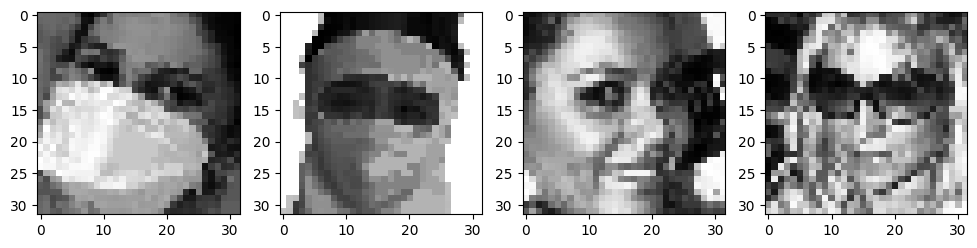

In [20]:
# Convierte x_train en una lista de imágenes
lista_de_imagenes = x_train.tolist()
imagenes_seleccionadas = random.sample(lista_de_imagenes, 4)
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

for i, imagen in enumerate(imagenes_seleccionadas):
    axs[i].imshow(imagen, cmap='gray')
plt.show()

In [21]:
x_train = x_train.reshape(-1, 32, 32, 1)
x_test = x_test.reshape(-1, 32, 32, 1)
x_validation = x_validation.reshape(-1, 32, 32, 1)
print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(10000, 32, 32, 1)
(992, 32, 32, 1)
(800, 32, 32, 1)


In [22]:
#Dividir el proceso de entrenamiento en bloques
#Aplicar aumentación de datos a un conjunto de datos (Data Augmentation)
from keras.preprocessing.image import ImageDataGenerator
dataGen = ImageDataGenerator(width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             zoom_range = 0.2,
                             shear_range = 0.2,
                             rotation_range = 20
                            )

dataGen.fit(x_train)

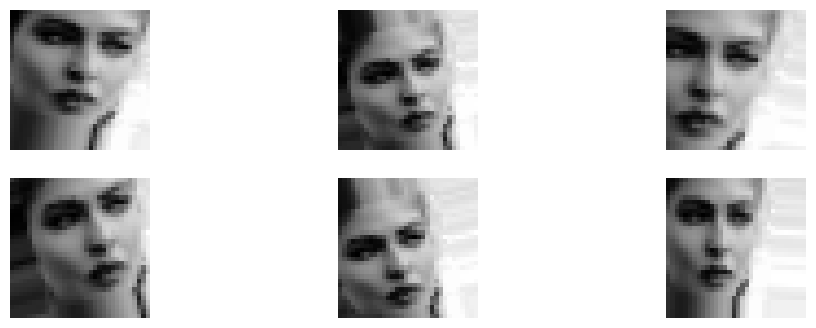

In [23]:
from PIL import Image
imagen_ejemplo = x_train[0]
imagen_ejemplo = np.expand_dims(imagen_ejemplo, axis=0)

# Genera imágenes aumentadas a partir de la imagen de ejemplo
generador = dataGen.flow(imagen_ejemplo, batch_size=1)

# Muestra las imágenes generadas
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    batch = generador.next()
    imagen_generada = batch[0]
    plt.imshow(imagen_generada.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [24]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 45,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_gen = train_datagen.flow_from_directory('Face Mask Dataset/Train',
                                              target_size = (150,150), batch_size = 64,
                                              class_mode = 'categorical',  color_mode= 'rgb')
val_gen = train_datagen.flow_from_directory('Face Mask Dataset/Validation',
                                            target_size=(150,150), class_mode='categorical', color_mode= 'rgb',
                                            batch_size= 64)
test_gen = test_datagen.flow_from_directory('Face Mask Dataset/Test',
                                            target_size = (150,150), class_mode = 'categorical',color_mode= 'rgb',
                                            batch_size = 64)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


### 2.2 Codificador de etiquetas

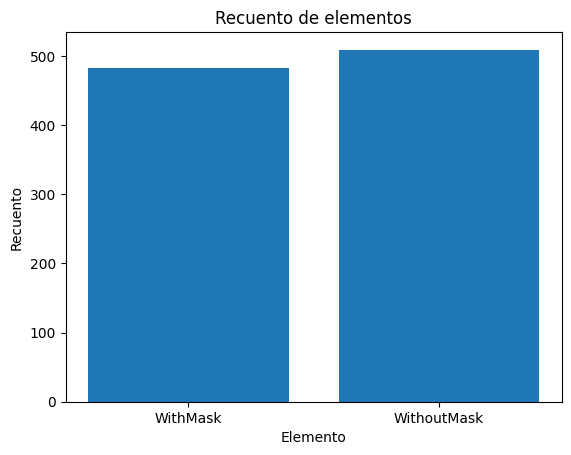

['WithMask' 'WithoutMask'] [483 509]


In [25]:
clases_y_test = y_test
valores_unicos, recuentos = np.unique(clases_y_test, return_counts=True)
plt.bar(valores_unicos, recuentos)
plt.xlabel('Elemento')
plt.ylabel('Recuento')
plt.title('Recuento de elementos')
plt.show()
print(valores_unicos, recuentos)

In [26]:
#Normalizar las etiquetas
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.fit_transform(y_test)
y_validation = label.fit_transform(y_validation)
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)

(10000,)
(992,)
(800,)


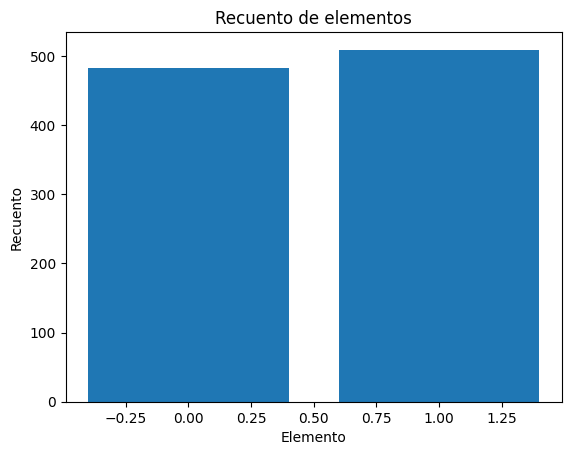

[0 1] [483 509]


In [27]:
clases_y_test = y_test
valores_unicos, recuentos = np.unique(clases_y_test, return_counts=True)
plt.bar(valores_unicos, recuentos)
plt.xlabel('Elemento')
plt.ylabel('Recuento')
plt.title('Recuento de elementos')
plt.show()
print(valores_unicos, recuentos)

### 2.3 Conversión

In [28]:
#Convierte un vector de clase (enteros) en una matriz de clase binaria.
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 131)
y_test = to_categorical(y_test, 131)
y_validation = to_categorical(y_validation, 131)
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)

(10000, 131)
(992, 131)
(800, 131)


In [29]:
print(y_train)
print(y_test)
print(y_validation)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## 3 Red neuronal convolucional (CNN)

### 3.1 Modelo CNN

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

model = Sequential()
#Primera capa
model.add(Conv2D(input_shape = (32,32,1), filters = 20, kernel_size = (5,5),
                 activation = "relu", padding = "same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1)) #Evita el sobreajuste

#Segunda capa
model.add(Conv2D(filters = 40, kernel_size = (3,3), activation = "relu", padding = "same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

#Tercera capa
model.add(Conv2D(filters=80, kernel_size=(3,3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

#Aplanan las características en un vector unidimensional
model.add(Flatten())
model.add(Dense(units=1024, activation = "relu"))
model.add(Dense(units=512, activation = "relu"))
model.add(Dense(units=131, activation = "softmax"))

#Compilación
model.compile(loss = "categorical_crossentropy",
              optimizer=("Adam"),
              metrics = ["accuracy"]
             )

cnn = model.fit(x_train,
                 y_train,
                 validation_data = (x_validation, y_validation),
                 epochs = 15)

Epoch 1/15
313/313 [==============================] - 26s 78ms/step - loss: 0.3849 - accuracy: 0.8235 - val_loss: 0.1055 - val_accuracy: 0.9663
Epoch 2/15
313/313 [==============================] - 24s 76ms/step - loss: 0.1045 - accuracy: 0.9617 - val_loss: 0.1603 - val_accuracy: 0.9450
Epoch 3/15
313/313 [==============================] - 25s 79ms/step - loss: 0.0859 - accuracy: 0.9678 - val_loss: 0.0833 - val_accuracy: 0.9712
Epoch 4/15
313/313 [==============================] - 25s 79ms/step - loss: 0.0716 - accuracy: 0.9741 - val_loss: 0.1060 - val_accuracy: 0.9625
Epoch 5/15
313/313 [==============================] - 24s 77ms/step - loss: 0.0578 - accuracy: 0.9789 - val_loss: 0.0661 - val_accuracy: 0.9775
Epoch 6/15
313/313 [==============================] - 24s 77ms/step - loss: 0.0555 - accuracy: 0.9801 - val_loss: 0.0533 - val_accuracy: 0.9850
Epoch 7/15
313/313 [==============================] - 24s 77ms/step - loss: 0.0444 - accuracy: 0.9829 - val_loss: 0.0528 - val_accuracy:

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 20)        520       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 20)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 40)        7240      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 40)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 40)          0

In [41]:
!pip install pydot
!pip install graphviz

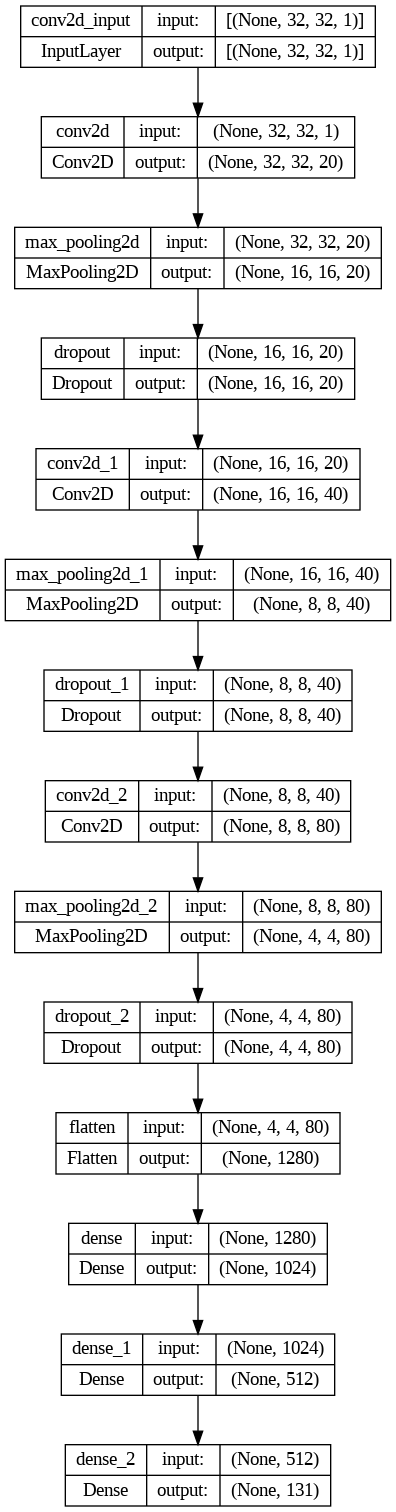

In [48]:
from keras.utils import plot_model

plot_model(model, to_file='modelo.png', show_shapes=True, show_layer_names=True)

### 3.2 Resultados

Text(0, 0.5, 'Precisión')

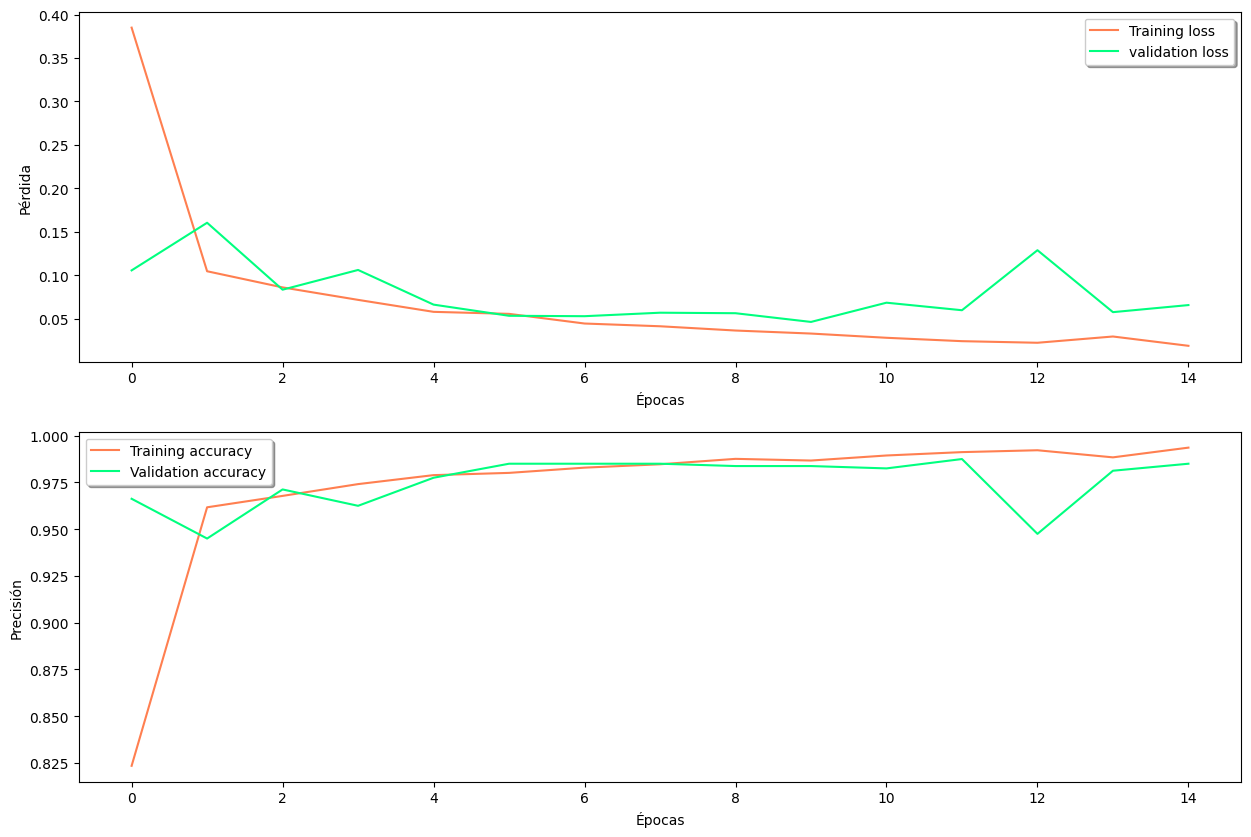

In [32]:
# Pérdida
fig, ax = plt.subplots(2,1, figsize=(15, 10))
ax[0].plot(cnn.history['loss'], color='coral', label="Training loss")
ax[0].plot(cnn.history['val_loss'], color='springgreen', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[0].set_xlabel("Épocas")  # Etiqueta del eje x
ax[0].set_ylabel("Pérdida")  # Etiqueta del eje y

#Precisión
ax[1].plot(cnn.history['accuracy'], color='coral', label="Training accuracy")
ax[1].plot(cnn.history['val_accuracy'], color='springgreen',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].set_xlabel("Épocas")  # Etiqueta del eje x
ax[1].set_ylabel("Precisión")  # Etiqueta del eje y

In [33]:
# Evaluar el modelo en el conjunto de datos de prueba
results = model.evaluate(x_test, y_test)
loss = results[0]
accuracy = results[1]

31/31 [==============================] - 1s 30ms/step - loss: 0.0619 - accuracy: 0.9829


In [34]:
print("Pérdida en el conjunto de prueba:", loss)
print("Precisión en el conjunto de prueba:", accuracy)

Pérdida en el conjunto de prueba: 0.06192667782306671
Precisión en el conjunto de prueba: 0.9828628897666931


In [35]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predice los valores del conjunto de datos de validación.
Y_pred = model.predict(x_validation)

# Convierte las salidas de la red neuronal en clases discretas.
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Convierte las etiquetas verdaderas de formato one-hot encoding en clases discretas.
Y_true = np.argmax(y_validation,axis = 1)

25/25 [==============================] - 1s 19ms/step


In [36]:
# Predice los valores del conjunto de datos de validación.
Y_pred_2 = model.predict(x_test)

# Convierte las salidas de la red neuronal en clases discretas.
Y_pred_classes_2 = np.argmax(Y_pred_2,axis = 1)

# Convierte las etiquetas verdaderas de formato one-hot encoding en clases discretas.
Y_true_2 = np.argmax(y_test,axis = 1)

31/31 [==============================] - 1s 18ms/step


In [37]:
from sklearn.metrics import classification_report
print(classification_report(Y_true_2, Y_pred_classes_2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       483
           1       0.98      0.98      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



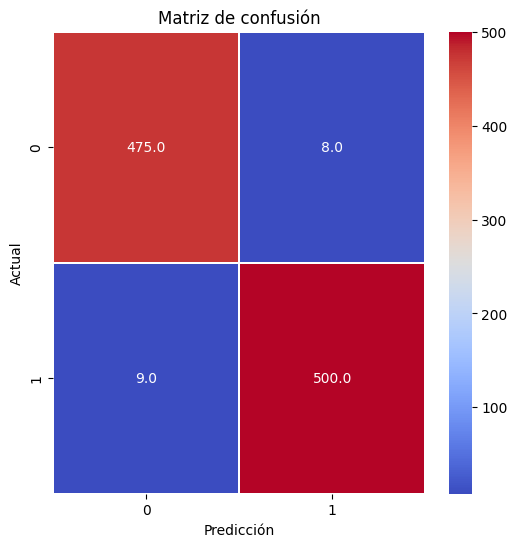

In [38]:
# Matriz de confusión.
confusion_mtx_2 = confusion_matrix(Y_true_2, Y_pred_classes_2)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_mtx_2, annot=True,
            linewidths=0.01,cmap="coolwarm",
            linecolor="white",
            fmt= '.1f',ax=ax)

plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.title("Matriz de confusión")
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.99      0.98      0.98       400

    accuracy                           0.98       800
   macro avg       0.99      0.99      0.98       800
weighted avg       0.99      0.98      0.98       800



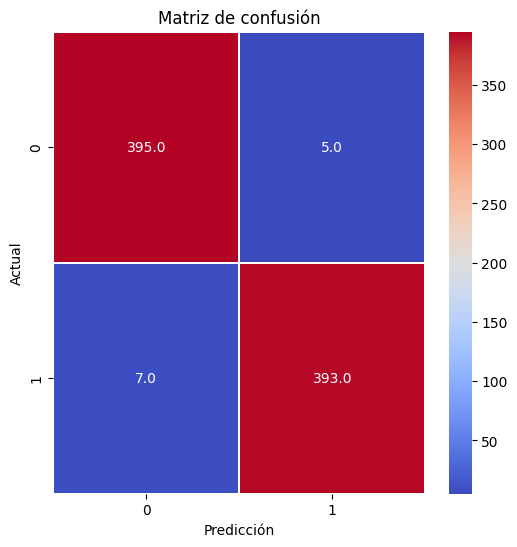

In [40]:
# Matriz de confusión.
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,cmap="coolwarm",
            linecolor="white",
            fmt= '.1f',ax=ax)

plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.title("Matriz de confusión")
plt.show()